# TEF Budget

Demonstration of accurate velocity and salinity extraction for a control volume defined by one or more sections.

Performs water and salt balances, calculating the imbalance (error) and plotting it on a time series. Tidal averaging will reduce the apparent magnitude of the errors by removing the tidal component. Some of this error is irrelevant to the TEF extraction, and is introduced from interpolating $dV/dt$ on a 1-hour interval. I have found that the error reduces quite a bit, from ~60% to 20% of $Q_R$, when a separate hydrodynamic run is made with a 1/2-hour output interval. When tidally averaging, though, this difference doesn't really matter. The code in this notebook is smart enough to handle the difference in output frequency between the two sets of NetCDF files.

In [1]:
hydro_output_cdf = '/home/benr/wqmodels/ssm/newinputs/4.6_icm4_1hr/wqm_year1/outputs/ssm_FVCOMICM_*.nc'
hydro_output_start = '2014-01-01'
rivers_cdf = '../input_files/data/ssm_pnt_2014_v3.nc'
extracts_path = '/home/benr/wqmodels/lo/LiveOcean_output/tef/wqm1hr'
section_names = ['HoodCanalEntrance']
run_name = 'wqm1hr_hoodcanal_tideavg'
statevars = ['NH4','NO3','DOXG']
rates = {
    'DOXG': ['REAERDO'],
    'NO3': ['JNO3TM1S'],
    'NH4': ['JNH4TM1S']
}

tide_avg = True

from glob import glob
import os
import os.path as path
from multiprocessing import Pool
import pickle

from netCDF4 import Dataset, MFDataset
import networkx as nx
import numpy as np
from scipy.interpolate import interp1d
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Memory
from fvcom.grid import FvcomGrid
from fvcom.depth import DepthCoordinate
from fvcom.transect import Transect
from fvcom.control_volume import ControlVolume

# From LiveOcean; add LiveOcean/alpha to conda.pth
from zfun import filt_godin

In [2]:
out_file = lambda name: path.join("notebook_outs", run_name, name)
os.makedirs(os.path.dirname(out_file('foo')), exist_ok=True)
memory = Memory(path.join("notebook_outs"))

In [3]:
hydro_output = MFDataset(hydro_output_cdf)
for s in statevars:
    assert s in hydro_output.variables, f'Constituent {s} is not in the model output'
for r in np.concatenate(list(rates.values())):
    assert r in hydro_output.variables, f'Rate {r} is not in the model output'
hydro_output

<class 'netCDF4._netCDF4.MFDataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: 
    institution: DOE/PNNL/MSL/BSRC
    source: FVCOM-ICM 3.0
    history: model started at: 21/04/2023   10:11
    Conventions: CF-1.0
    dimensions = ('scalar', 'node', 'nele', 'siglay', 'siglev', 'three', 'four', 'nine', 'time')
    variables = ('nprocs', 'partition', 'Initial_Density', 'x', 'y', 'siglay', 'siglev', 'h', 'nv', 'time', 'iint', 'zeta', 'u', 'v', 'salinity', 'temp', 'depth', 'CCHL1', 'DOXG', 'B1', 'B2', 'NH4', 'NO3', 'LDON', 'RDON', 'LPON', 'RPON', 'PO4', 'IAVG', 'REAERDO', 'JNO3TM1S', 'JNH4TM1S')
    groups = ()

In [4]:
grid = FvcomGrid.from_output(hydro_output)
dcoord = DepthCoordinate.from_output(hydro_output)
grid

FvcomGrid(ncoord=array([[4.1320981e+05, 4.0058141e+05, 3.9043006e+05, ..., 4.9810700e+05,
        4.9905700e+05, 4.9871100e+05],
       [4.9160915e+06, 4.9165735e+06, 4.9164565e+06, ..., 5.2337970e+06,
        5.2338140e+06, 5.2341420e+06],
       [1.0275730e+02, 1.6055827e+02, 1.6055827e+02, ..., 4.0000000e+00,
        4.0000000e+00, 4.0000000e+00]], dtype=float32), nv=masked_array(
  data=[[   88,    88,     2, ..., 16008, 16009, 16009],
        [   89,     1,    90, ..., 16009, 16012, 16010],
        [    1,     2,    88, ..., 16011, 16011, 16012]],
  mask=False,
  fill_value=999999), calc=True)

In [5]:
section_files = {}
section_extractions = {}
transects = []
for s in section_names:
    f = path.join(extracts_path, 'extractions/' + s + '.nc')
    section_files[s] = f
    section_extractions[s] = Dataset(f)
    transects.append(Transect(grid, section_extractions[s]['ele'][:]))
    display(section_extractions[s])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    gtagex: wqm1hr
    date_string0: 2014.01.01
    date_string1: 2014.12.31
    vn_list: salt,NH4,NO3,DOXG
    dimensions(sizes): xi_sect(6), s_z(10), ocean_time(8760), sdir_str(2), xy(2)
    variables(dimensions): float64 ocean_time(ocean_time), float64 salt(ocean_time, s_z, xi_sect), float64 NH4(ocean_time, s_z, xi_sect), float64 NO3(ocean_time, s_z, xi_sect), float64 DOXG(ocean_time, s_z, xi_sect), float64 q(ocean_time, s_z, xi_sect), float64 z0(s_z, xi_sect), float64 DA0(s_z, xi_sect), float64 lon(xi_sect), float64 lat(xi_sect), float64 h(xi_sect), int64 ele(xi_sect), float64 zeta(ocean_time, xi_sect)
    groups: 

# Define the Control Volume

In [6]:
cv = ControlVolume(transects)
cv_nodes = cv.nodes
print(f'{len(cv_nodes)} Control Volume nodes')
cv_node_list = np.array(list(cv_nodes))

729 Control Volume nodes


# Extract Control Volume Data from Model Outputs

In [7]:
node_tces = grid.tces_gdf()
node_tces.head()

,geometry
1,"POLYGON ((413506.938 4920788.000, 410871.844 4..."
2,"POLYGON ((395505.750 4916515.000, 400581.406 4..."
3,"POLYGON ((395505.750 4916515.000, 395667.781 4..."
4,"POLYGON ((385530.031 4917393.000, 385541.844 4..."
5,"POLYGON ((378155.000 4921735.000, 380625.156 4..."


In [8]:
node_areas = node_tces.loc[cv_node_list, 'geometry'].area.to_numpy()

# From https://stackoverflow.com/a/312464
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

@memory.cache
def extract_data(hydro_output_pattern, statevars=[], rates=[]):
    all_files = glob(hydro_output_pattern)
    all_files.sort()

    allVs = []
    allVSs = []
    allVCs = {s: [] for s in statevars}
    allRs = {r: [] for r in rates}
    cv_h = hydro_output['h'][cv_node_list-1]
    for cdfchunk in chunks(all_files, 4):
        with MFDataset(cdfchunk) if len(cdfchunk) > 1 else Dataset(cdfchunk[0]) as ds:
            zetas = ds['zeta'][:,cv_node_list-1]
            total_vol = node_areas * (np.expand_dims(dcoord.dz, 1) @ np.expand_dims(cv_h, 0))
            # Adjust for tides
            total_vol = total_vol * (1 + np.swapaxes(np.broadcast_to(
                zetas / cv_h, (dcoord.kb - 1, zetas.shape[0], zetas.shape[1])
            ), 0, 1))
            # total_vol is now shape (time, kb-1, nodes)
            allVs.append(total_vol.sum(axis=(1,2)))
            s = ds['salinity'][:,:,cv_node_list-1]
            allVSs.append((total_vol * s).sum(axis=(1,2)))
            for s in statevars:
                c = ds[s][:,:,cv_node_list-1]
                allVCs[s].append((total_vol * c).sum(axis=(1,2)))
            for r in rates:
                v = ds[r]
                if 'siglay' in v.dimensions:
                    d = ds[r][:,:,cv_node_list-1]
                    allRs[r].append((total_vol * d).sum(axis=(1,2)))
                else:
                    d = ds[r][:,cv_node_list-1]
                    allRs[r].append((node_areas * d).sum(axis=1))
    V = np.concatenate(allVs)
    VS = np.concatenate(allVSs)
    VC = {s: np.concatenate(allVCs[s]) for s in statevars}
    R = {r: np.concatenate(allRs[r]) for r in rates}

    return (V, VS, VC, R)

V, VS, VC, R = extract_data(hydro_output_cdf, statevars, np.concatenate(list(rates.values())))
display(V.shape)
V

(8760,)

masked_array(data=[24523284394.145523, 24373627867.08748,
                   24310229591.552753, ..., 25095259518.71206,
                   25390757386.878773, 25669206450.315983],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

## Unit conversions

All rates are per day, so convert them to per sec for later use.

Also, sediment flux rates are in mg rather than g

In [9]:
for r in np.concatenate(list(rates.values())):
    R[r] /= 86400
    if r.endswith('TM1S'):
        R[r] /= 1000

# Volume Balance

## Get CV Volume Change

In [10]:
# This simple method is not accurate enough. It's a lagged difference
# that introduces errors on a tidal frequency
# See https://stackoverflow.com/a/18993405
#dVdt = np.diff(V) / np.diff(hydro_output['time'][:])
dVdt = ndimage.gaussian_filter1d(V, sigma=1, order=1)[1:] / np.diff(hydro_output['time'][:])
display(dVdt.shape)
dVdt

(8759,)

array([-20063.0077196 ,  -4527.73961881,  21733.70884889, ...,
        75490.11748244,  67034.33354046,  28619.22331524])

## Tidal transport in and out of section ($Q_\mathrm{prism}$)

In [11]:
qpr_in = {}
qpr_out = {}
transect_directions = cv.transect_directions()
for s, d in zip(section_names, transect_directions):
    direction = 1 if d else -1
    ds = section_extractions[s]
    # shape becomes (s_z, xi_sect, time)
    q = np.moveaxis(ds['q'][:], 0, 2)
    # shape becomes (xi_sect, time)
    qpr_in[s] = (np.where(q * direction > 0, q, 0) * direction).sum(axis=(0,1))
    qpr_out[s] = (np.where(q * direction < 0, q, 0) * direction).sum(axis=(0,1))
    display(f'q_prism,in {s}', qpr_in[s])
    display(f'q_prism,out {s}', qpr_out[s])

'q_prism,in HoodCanalEntrance'

array([ 1962.77143092,  4251.46981334,   492.39865242, ...,
       78837.49822461, 83040.33314916, 67389.5012288 ])

'q_prism,out HoodCanalEntrance'

array([-23237.64718542, -11587.21572294, -34353.31303953, ...,
            0.        ,      0.        ,      0.        ])

## Get River Discharges into CV

Rivers discharge into nodes that are listed in `cv_nodes`. Discharges must be interpolated to the output frequency of the model.

In [12]:
rivers = Dataset(rivers_cdf)
rivers

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(366), node(259), siglay(10)
    variables(dimensions): float32 time(time), int32 node(node), float32 vqdist(node, siglay), float32 discharge(time, node), float32 temp(time, node), float32 salt(time, node), float32 tss(time, node), float32 alg1(time, node), float32 alg2(time, node), float32 alg3(time, node), float32 zoo1(time, node), float32 zoo2(time, node), float32 ldoc(time, node), float32 rdoc(time, node), float32 lpoc(time, node), float32 rpoc(time, node), float32 nh4(time, node), float32 no32(time, node), float32 urea(time, node), float32 ldon(time, node), float32 rdon(time, node), float32 lpon(time, node), float32 rpon(time, node), float32 po4(time, node), float32 ldop(time, node), float32 rdop(time, node), float32 lpop(time, node), float32 rpop(time, node), float32 pip(time, node), float32 cod(time, node), float32 doxg(time, node), float32 psi(time, node), float32 ds

In [13]:
rivers_in_cv = set(rivers['node'][:]) & cv_nodes
rivers_in_cv

{7854,
 8279,
 8554,
 9784,
 11205,
 11206,
 11508,
 11591,
 11592,
 11602,
 11867,
 12872,
 12873,
 13429,
 13626,
 13833,
 13834,
 14138,
 14139,
 14211,
 14235}

(366,)

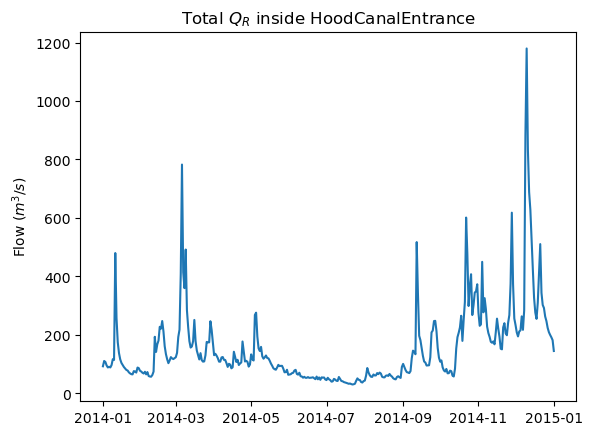

In [14]:
if len(rivers_in_cv) == 0:
    river_qs = np.zeros_like(rivers['time'][:])
else:
    rivers_idxs = np.where(np.isin(np.ma.getdata(rivers['node'][:]),
                                   list(rivers_in_cv)))[0]
    river_qs = rivers['discharge'][:,rivers_idxs].sum(axis=1)
display(river_qs.shape)
fig, ax = plt.subplots()
river_dates = pd.Timestamp(hydro_output_start) + pd.to_timedelta(rivers['time'][:], 'H')
ax.plot(river_dates, river_qs)
ax.set(ylabel='Flow ($m^3/s$)', title=f'Total $Q_R$ inside {", ".join(section_names)}')
fig.savefig(out_file('qr.png'))

In [15]:
onesect = next(iter(section_names))

# model output times are in seconds
# Get times from a section extraction since they are at a guaranteed 1-hr frequency
section_dates = pd.Timestamp('1970-01-01') + pd.to_timedelta(section_extractions[onesect]['ocean_time'][:], 's')
# Convert dates back to seconds since the start of the model run
section_output_times = ((section_dates - pd.Timestamp(section_extractions[onesect].date_string0)) /
                      np.timedelta64(1, 's')).astype(int).to_numpy()
# The output times from the model run may be at a higher frequency, but there should be overlap
model_output_times = hydro_output['time'][:]
# river times are in hours; convert them
river_times = rivers['time'][:] * 3600
# The model can potentially run past the boundary conditions, and if that
# happened we need to truncate the output
cut_indices_model = (model_output_times > river_times.max()).nonzero()[0]
if len(cut_indices_model) > 0:
    time_removed_model = (model_output_times[cut_indices_model.max()] -
                          model_output_times[cut_indices_model.min()]) / 87600
    print(f'Need to remove {time_removed_model:.2f} days of model output from end of run')
    right_cut_model = cut_indices_model.min()
    right_cut_deriv = right_cut_model - 1
    model_output_times = model_output_times[:right_cut_model]
else:
    right_cut_model = None
    right_cut_deriv = None
cut_indices_section = (section_output_times > river_times.max()).nonzero()[0]
if len(cut_indices_section) > 0:
    right_cut_section = cut_indices_section.min()
    section_output_times = section_output_times[:right_cut_section]
    section_dates = section_dates[:right_cut_section]
else:
    right_cut_section = None
rivers_interp = interp1d(river_times, river_qs)(section_output_times)
print(f't: {len(section_dates)}; QR: {len(river_times)}; Qin/out: {len(qpr_in[onesect])}')

t: 8760; QR: 366; Qin/out: 8760


## Perform Volume Balance and Plot Result

In [16]:
model_dates = pd.Timestamp(hydro_output_start) + pd.to_timedelta(model_output_times[:], 's')
model_df = pd.DataFrame({'$dV/dt$': dVdt[:right_cut_deriv]},
                        index=model_dates[1:])
section_data = {}
for x in section_names:
    section_data[x + ' $Q_\mathrm{prism,in}$'] = qpr_in[x][:right_cut_section]
    section_data[x + ' $Q_\mathrm{prism,out}$'] = qpr_out[x][:right_cut_section]
section_data['$Q_R$'] = rivers_interp
vol_budget = model_df.merge(pd.DataFrame(section_data, index=section_dates), how='left', left_index=True, right_index=True)
vol_budget.dropna().tail()

,$dV/dt$,"HoodCanalEntrance $Q_\mathrm{prism,in}$","HoodCanalEntrance $Q_\mathrm{prism,out}$",$Q_R$
2014-12-31 19:59:20,50689.873925,59399.662793,-671.087199,151.326310
2014-12-31 20:59:20,68337.089682,72241.977498,-395.024256,149.775324
2014-12-31 21:59:20,75490.117482,78837.498225,0.000000,148.224338
2014-12-31 22:59:20,67034.333540,83040.333149,0.000000,146.673352
2014-12-31 23:59:20,28619.223315,67389.501229,0.000000,145.122366


In [17]:
if tide_avg:
    # We have to make all the data hourly in order for the tidal averaging to work correctly
    vol_budget.dropna(inplace=True)
    for c in vol_budget.columns:
        vol_budget[c] = filt_godin(vol_budget[c].to_numpy())
    display(vol_budget.dropna().tail())

,$dV/dt$,"HoodCanalEntrance $Q_\mathrm{prism,in}$","HoodCanalEntrance $Q_\mathrm{prism,out}$",$Q_R$
2014-12-30 08:59:20,9.770591,23420.397565,-23593.592688,187.595934
2014-12-30 09:59:20,8.069005,23413.078052,-23587.259120,187.065341
2014-12-30 10:59:20,6.198127,23408.038524,-23583.265994,186.513039
2014-12-30 11:59:20,3.719249,23405.168439,-23581.344725,185.937291
2014-12-30 12:59:20,-1.450299,23403.595538,-23580.660901,185.336290


In [18]:
vol_budget['error'] = -vol_budget['$dV/dt$'] + vol_budget[vol_budget.columns[1:]].sum(1)
vol_budget.loc[vol_budget['$Q_R$'].isna(), 'error'] = np.nan
vol_budget.to_excel(out_file('vol_budget.xlsx'))
vol_budget.dropna().tail()

,$dV/dt$,"HoodCanalEntrance $Q_\mathrm{prism,in}$","HoodCanalEntrance $Q_\mathrm{prism,out}$",$Q_R$,error
2014-12-30 08:59:20,9.770591,23420.397565,-23593.592688,187.595934,4.630220
2014-12-30 09:59:20,8.069005,23413.078052,-23587.259120,187.065341,4.815268
2014-12-30 10:59:20,6.198127,23408.038524,-23583.265994,186.513039,5.087443
2014-12-30 11:59:20,3.719249,23405.168439,-23581.344725,185.937291,6.041756
2014-12-30 12:59:20,-1.450299,23403.595538,-23580.660901,185.336290,9.721226


Error:          0.87 cms (0.57% of mean Q_R)
Error per $dV/dt$: 114.23%
RMSE:           0.12 cms (0.08% of mean Q_R)


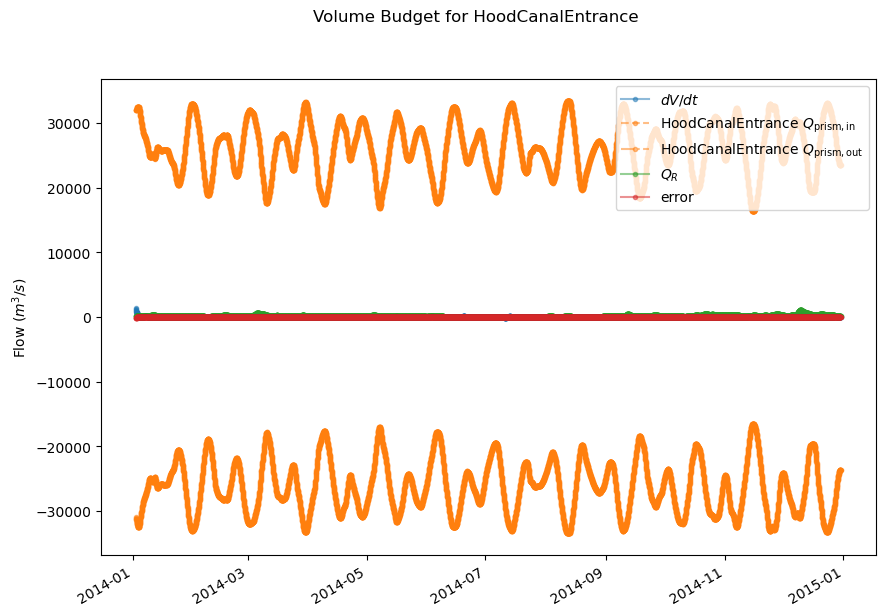

In [19]:
def plot_budget(df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,7))
    else:
        fig = None
    l = None
    for c in df.columns:
        color = None
        if c[-5:-2] == 'out':
            color = l[0].get_color()
            linestyle = '.-.'
        elif c[-4:-2] == 'in':
            linestyle = '.--'
        else:
            linestyle = '.-'
        l = ax.plot(df[c].dropna(), linestyle, color=color, label=c, alpha=0.5)
    return fig, ax

fig, ax = plot_budget(vol_budget)
qr = vol_budget['$Q_R$'].dropna()
if not tide_avg:
    ax.set(xbound=(qr.index[8400], qr.index[8460]))
ax.set(ylabel="Flow ($m^3/s$)")
ax.legend()
fig.autofmt_xdate()
fig.suptitle(f'Volume Budget for {", ".join(section_names)}')
fig.savefig(out_file('vol_budget.png'))

def error_stats(df, unit, fudge=0):
    cvchg = df.columns[0]
    err_cols = [cvchg,'$Q_R$','error'] if '$Q_R$' in df.columns else [cvchg, 'error']
    error = df[err_cols].dropna()
    mean_error = error['error'][fudge:].mean()
    if '$Q_R$' in df.columns:
        error_per_qr = np.nan if error['$Q_R$'].mean() == 0 else mean_error / error['$Q_R$'].mean()
        print(f'Error:          {mean_error:.2f} {unit} ({error_per_qr * 100:.2f}% of mean Q_R)')
    else:
        print(f'Error:          {mean_error:.2f} {unit}')
    error_per_cvchg = np.abs(mean_error / error[cvchg][fudge:].mean())
    print(f'Error per {cvchg}: {error_per_cvchg*100:.2f}%')
    rmse = np.sqrt((error['error'] ** 2).sum())/len(error['error'])
    if '$Q_R$' in df.columns:
        rmse_per_qr = np.nan if error['$Q_R$'].mean() == 0 else rmse / error['$Q_R$'].mean()
        print(f'RMSE:           {rmse:.2f} {unit} ({rmse_per_qr * 100:.2f}% of mean Q_R)')
    else:
        print(f'RMSE:           {rmse:.2f} {unit}')

error_stats(vol_budget, 'cms', fudge=83)

# Salt Balance

## Calculate d(VS)/dt

First get the total volume broken down by node, layer, and time index

In [20]:
dVSdt = ndimage.gaussian_filter1d(VS, sigma=1, order=1)[1:] / np.diff(hydro_output['time'][:])
display(dVSdt.shape)
dVSdt

(8759,)

array([-597073.27491062, -132629.75538895,  652212.45850287, ...,
       2204228.38766267, 1958617.73581   ,  836709.51480544])

## Calculate salinity fluxes in and out

In [21]:
qspr_in = {}
qspr_out = {}
transect_directions = cv.transect_directions()
for s, d in zip(section_names, transect_directions):
    direction = 1 if d else -1
    ds = section_extractions[s]
    # shape becomes (s_z, xi_sect, time)
    q = np.moveaxis(ds['q'][:], 0, 2)
    salt = np.moveaxis(ds['salt'][:], 0, 2)
    # shape becomes (xi_sect, time)
    tide_adj = (1 + ds['zeta'][:] / ds['h'][:]).T
    qspr_in[s] = (np.where(q * direction > 0, q, 0) * salt * tide_adj * direction).sum(axis=(0,1))
    qspr_out[s] = (np.where(q * direction < 0, q, 0) * salt * tide_adj * direction).sum(axis=(0,1))
    display(f'qs_in {s}', qspr_in[s])
    display(f'qs_out {s}', qspr_out[s])

'qs_in HoodCanalEntrance'

masked_array(data=[58768.684870508936, 125933.88922308516,
                   14471.700013189373, ..., 2327672.0361218,
                   2483996.714736783, 2034184.1234070633],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

'qs_out HoodCanalEntrance'

masked_array(data=[-680719.0147646654, -337205.70728163054,
                   -993118.0889879634, ..., 0.0, 0.0, 0.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

## Perform Salt Balance and Plot Result

In [22]:
model_salt_df = pd.DataFrame({'$d(VS)/dt$': dVSdt[:right_cut_deriv]}, index=model_dates[1:])
salt_section_data = {}
for x in section_names:
    salt_section_data[x + ' $QS_\mathrm{prism,in}$'] = qspr_in[x][:right_cut_section]
    salt_section_data[x + ' $QS_\mathrm{prism,out}$'] = qspr_out[x][:right_cut_section]
salt_budget = model_salt_df.merge(pd.DataFrame(salt_section_data, index=section_dates),
                                  how='left', left_index=True, right_index=True)
salt_budget.dropna().tail()

,$d(VS)/dt$,"HoodCanalEntrance $QS_\mathrm{prism,in}$","HoodCanalEntrance $QS_\mathrm{prism,out}$"
2014-12-31 19:59:20,1.482960e+06,1.728019e+06,-18688.496476
2014-12-31 20:59:20,1.996216e+06,2.111951e+06,-11117.006946
2014-12-31 21:59:20,2.204228e+06,2.327672e+06,0.000000
2014-12-31 22:59:20,1.958618e+06,2.483997e+06,0.000000
2014-12-31 23:59:20,8.367095e+05,2.034184e+06,0.000000


In [23]:
if tide_avg:
    # We have to make all the data hourly in order for the tidal averaging to work correctly
    salt_budget.dropna(inplace=True)
    for c in salt_budget.columns:
        salt_budget[c] = filt_godin(salt_budget[c].to_numpy())
    display(salt_budget.dropna().tail())

,$d(VS)/dt$,"HoodCanalEntrance $QS_\mathrm{prism,in}$","HoodCanalEntrance $QS_\mathrm{prism,out}$"
2014-12-30 08:59:20,-5729.410065,697434.260984,-702533.789725
2014-12-30 09:59:20,-5750.106522,697229.619336,-702315.621614
2014-12-30 10:59:20,-5772.171263,697092.889856,-702164.776151
2014-12-30 11:59:20,-5809.088085,697019.313076,-702073.149884
2014-12-30 12:59:20,-5921.722595,696982.267993,-702016.034348


In [24]:
salt_budget['error'] = -salt_budget['$d(VS)/dt$'] + salt_budget[salt_budget.columns[1:]].sum(1, skipna=False)
salt_budget.to_excel(out_file('salt_budget.xlsx'))
salt_budget.dropna().tail()

,$d(VS)/dt$,"HoodCanalEntrance $QS_\mathrm{prism,in}$","HoodCanalEntrance $QS_\mathrm{prism,out}$",error
2014-12-30 08:59:20,-5729.410065,697434.260984,-702533.789725,629.881324
2014-12-30 09:59:20,-5750.106522,697229.619336,-702315.621614,664.104244
2014-12-30 10:59:20,-5772.171263,697092.889856,-702164.776151,700.284968
2014-12-30 11:59:20,-5809.088085,697019.313076,-702073.149884,755.251277
2014-12-30 12:59:20,-5921.722595,696982.267993,-702016.034348,887.956240


Error:          2647.33 psu-cms
Error per $d(VS)/dt$: 702.29%
RMSE:           39.51 psu-cms


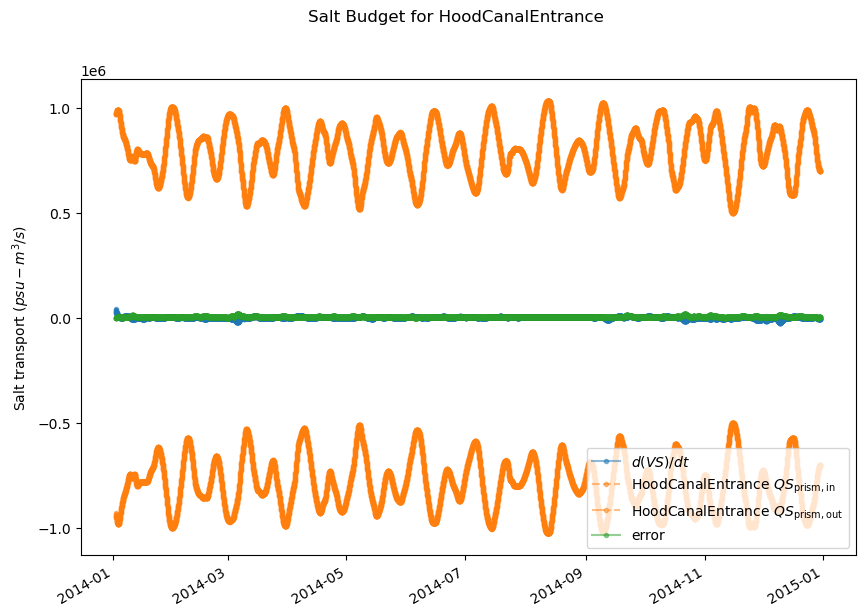

In [25]:
fig, ax = plot_budget(salt_budget)
if not tide_avg:
    ax.set(xbound=(section_dates[4400], section_dates[4460]))
ax.set(ylabel="Salt transport ($psu-m^3/s$)")
ax.legend()
fig.autofmt_xdate()
fig.suptitle(f'Salt Budget for {", ".join(section_names)}')
fig.savefig(out_file('salt_budget.png'))

error_stats(salt_budget, 'psu-cms')

# TEF Volume/Salt Budget

In [26]:
q_in = {}
q_out = {}
qs_in = {}
qs_out = {}
qc_in = {s: {} for s in statevars}
qc_out = {s: {} for s in statevars}
# FIXME apply transect_directions multiplier to reverse flow of certain
# transects defining the CV. Not a problem for single-transect CVs
for s in section_names:
    with open(path.join(extracts_path, 'bulk', s + '.p'), 'rb') as f:
        bulk_result = pickle.load(f)
    qq = bulk_result['QQ']
    ss = bulk_result['SS']
    bulk_dates = pd.Timestamp('1/1/1970 00:00') + pd.to_timedelta(bulk_result['ot'].data, 'sec')
    qq_in = np.where(qq > 0, qq, 0)
    qq_out = np.where(qq < 0, qq, 0)
    q_in[s] = qq_in.sum(axis=1)
    q_out[s] = qq_out.sum(axis=1)
    qs_in[s] = np.nansum(qq_in * ss, axis=1)
    qs_out[s] = np.nansum(qq_out * ss, axis=1)
    if 'QQC' in bulk_result:
        for v in statevars:
            assert v in bulk_result['QQC'], f'Requested constituent {v} is not present in TEF data'
        for c,qqc in bulk_result['QQC'].items():
            if c not in qc_in:
                continue
            qqc_in = np.where(qqc > 0, qqc, 0)
            qqc_out = np.where(qqc < 0, qqc, 0)
            qc_in[c][s] = qqc_in.sum(axis=1)
            qc_out[c][s] = qqc_out.sum(axis=1)

In [27]:
model_df = pd.DataFrame({'$dV/dt$': dVdt[:right_cut_deriv]}, index=model_dates[1:])
# Filter just the section dates (hourly) and tidally average
model_df = model_df.loc[model_df.index.isin(section_dates)].copy()
model_df['$dV/dt$'] = filt_godin(model_df['$dV/dt$'])
section_data = {}
for x in section_names:
    section_data[x + ' $Q_\mathrm{in}$']  = q_in[x]
    section_data[x + ' $Q_\mathrm{out}$'] = q_out[x]
qr_series = pd.Series(filt_godin(rivers_interp), index=section_dates, name='$Q_R$')

tef_vol_budget = (model_df.merge(pd.DataFrame(section_data, index=bulk_dates), how='left', left_index=True, right_index=True)
                  .merge(pd.DataFrame(qr_series), how='left', left_index=True, right_index=True))
tef_vol_budget['error'] = -tef_vol_budget['$dV/dt$'] + tef_vol_budget[tef_vol_budget.columns[tef_vol_budget.columns != '$dV/dt$']].sum(1)
tef_vol_budget.dropna(inplace=True)
tef_vol_budget.to_excel(out_file('tef_vol_budget.xlsx'))
tef_vol_budget.tail()

,$dV/dt$,HoodCanalEntrance $Q_\mathrm{in}$,HoodCanalEntrance $Q_\mathrm{out}$,$Q_R$,error
2014-12-25 12:59:20,50.611920,4165.385663,-4356.822306,254.647431,12.598868
2014-12-26 12:59:20,17.263803,4692.187393,-4893.747243,235.066724,16.243070
2014-12-27 12:59:20,106.643855,5478.559577,-5583.349107,216.893306,5.459920
2014-12-28 12:59:20,38.852674,3145.483703,-3301.780742,204.716343,9.566631
2014-12-29 12:59:20,27.833813,2952.203385,-3116.807131,195.736442,3.298882


Error:          0.54 cms (0.35% of mean Q_R)
Error per $dV/dt$: 11.35%
RMSE:           0.67 cms (0.43% of mean Q_R)


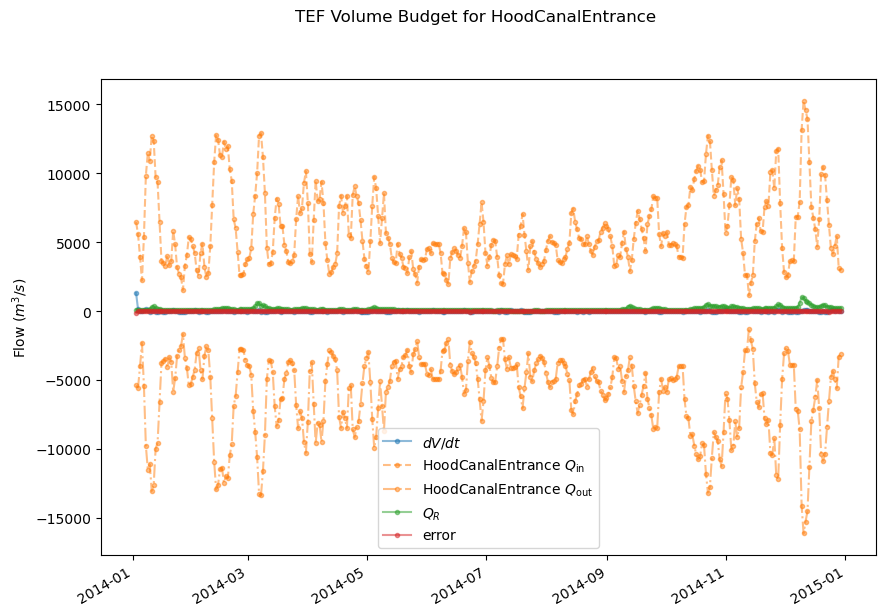

In [28]:
fig, ax = plot_budget(tef_vol_budget)
    
qr = tef_vol_budget['$Q_R$'].dropna()
#ax.set(xbound=(qr.index[8400], qr.index[8460]))
ax.set(ylabel="Flow ($m^3/s$)")
ax.legend()
fig.autofmt_xdate()
fig.suptitle(f'TEF Volume Budget for {", ".join(section_names)}')
fig.savefig(out_file('tef_vol_budget.png'))

error_stats(tef_vol_budget, 'cms')

In [29]:
model_salt_df = pd.DataFrame({'$d(VS)/dt$': dVSdt[:right_cut_deriv]}, index=model_dates[1:])
# Subsample using section_dates to ensure hourly output before passing to filt_godin
model_salt_df.loc[model_dates[1:].difference(section_dates), '$d(VS)/dt$'] = np.nan
model_salt_df.dropna(inplace=True)
model_salt_df['$d(VS)/dt$'] = filt_godin(model_salt_df['$d(VS)/dt$'])

salt_section_data = {}
for x in section_names:
    salt_section_data[x + ' $QS_\mathrm{in}$'] = qs_in[x]
    salt_section_data[x + ' $QS_\mathrm{out}$'] = qs_out[x]
tef_salt_budget = model_salt_df.merge(pd.DataFrame(salt_section_data, index=bulk_dates),
                                  how='left', left_index=True, right_index=True)
tef_salt_budget['error'] = -tef_salt_budget['$d(VS)/dt$'] + tef_salt_budget[tef_salt_budget.columns[1:]].sum(1)
tef_salt_budget.dropna(inplace=True)
tef_salt_budget.to_excel(out_file('tef_salt_budget.xlsx'))
tef_salt_budget.tail()

,$d(VS)/dt$,HoodCanalEntrance $QS_\mathrm{in}$,HoodCanalEntrance $QS_\mathrm{out}$,error
2014-12-25 12:59:20,-952.629320,123603.953491,-124004.558045,552.024766
2014-12-26 12:59:20,-770.191966,138922.072874,-138107.355213,1584.909626
2014-12-27 12:59:20,2192.138242,161847.408443,-157544.164588,2111.105613
2014-12-28 12:59:20,-1761.029858,92411.162993,-93838.590404,333.602447
2014-12-29 12:59:20,-4631.260987,85230.694176,-90053.647197,-191.692034


Error:          2154.43 psu-cms
Error per $d(VS)/dt$: 724.47%
RMSE:           175.34 psu-cms


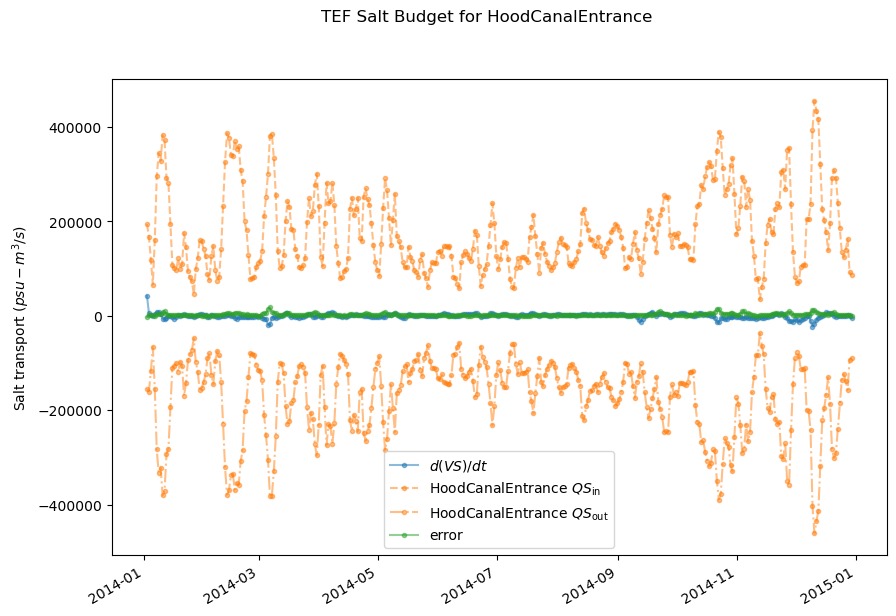

In [30]:
fig, ax = plot_budget(tef_salt_budget)
ax.set(ylabel="Salt transport ($psu-m^3/s$)")
ax.legend()
fig.autofmt_xdate()
fig.suptitle(f'TEF Salt Budget for {", ".join(section_names)}')
fig.savefig(out_file('tef_salt_budget.png'))

error_stats(tef_salt_budget, 'psu-cms')

## Other Constituent Budgets

In [31]:
# For each constituent in VC:
# - calculate derivative to get d(VC)/dt (tide avg)
# future: extract atmospheric, sediment, etc rates from model output if present and save w/ joblib (tide avg)
# - extract C_R from river input (tide avg)
#   NEED TO UPDATE INPUT FILE TO USE WQM VERSION
# - construct dataframe of budget
# - plot

In [32]:
dVCdt = {s: ndimage.gaussian_filter1d(VC[s], sigma=1, order=1)[1:] / np.diff(hydro_output['time'][:]) for s in statevars}
if len(statevars):
    dVCdt[statevars[0]]

In [33]:
model_river_cst_map = {
    'NH4': 'nh4',
    'NO3': 'no32',
    'DOXG': 'doxg'
}

if len(rivers_in_cv) == 0:
    river_qcs = {s: np.zeros_like(rivers['time'][:]) for s in statevars}
else:
    river_qcs = {}
    for s in statevars:
        river_qcs[s] = (rivers['discharge'][:,rivers_idxs] *
                        rivers[model_river_cst_map[s]][:,rivers_idxs]
                       ).sum(axis=1)
rivers_qc_interp = {s: interp1d(river_times, river_qcs[s])(section_output_times) for s in statevars}

In [34]:
tef_cst_budgets = {}
for s in statevars:
    model_deriv_df = pd.DataFrame({'$d(VC)/dt$': dVCdt[s][:right_cut_deriv]}, index=model_dates[1:])
    # Filter just the section dates (hourly) and tidally average
    model_deriv_df = model_deriv_df.loc[model_deriv_df.index.isin(section_dates)].copy()
    model_deriv_df['$d(VC)/dt$'] = filt_godin(model_deriv_df['$d(VC)/dt$'])
    section_data = {}
    for x in section_names:
        section_data[x + ' $Q^C_\mathrm{in}$']  = qc_in[s][x]
        section_data[x + ' $Q^C_\mathrm{out}$'] = qc_out[s][x]
    qr_series = pd.Series(filt_godin(rivers_qc_interp[s]), index=section_dates, name='$Q^C_R$')

    df = (model_deriv_df.merge(pd.DataFrame(section_data, index=bulk_dates), how='left', left_index=True, right_index=True)
          .merge(pd.DataFrame(qr_series), how='left', left_index=True, right_index=True))
    if s in rates:
        model_rates_df = pd.DataFrame(
            {r: filt_godin(R[r][:right_cut_model]) for r in rates[s]},
            index=model_dates)
        df = df.merge(model_rates_df, how='left', left_index=True, right_index=True)
    df['source/sink'] = df['$d(VC)/dt$'] - df[df.columns[df.columns != '$d(VC)/dt$']].sum(1)
    tef_cst_budgets[s] = df.dropna()
    tef_cst_budgets[s].to_excel(out_file(f'tef_{s}_budget.xlsx'))
if len(statevars):
    display(tef_cst_budgets[statevars[0]].tail())

,$d(VC)/dt$,HoodCanalEntrance $Q^C_\mathrm{in}$,HoodCanalEntrance $Q^C_\mathrm{out}$,$Q^C_R$,JNH4TM1S,source/sink
2014-12-25 12:59:20,-71.291568,43.896936,-46.970196,3.094976,156.988334,-228.301619
2014-12-26 12:59:20,-68.464937,48.656369,-52.788858,2.838777,155.581088,-222.752313
2014-12-27 12:59:20,-63.200364,56.181932,-59.534830,2.607018,154.370340,-216.824825
2014-12-28 12:59:20,-61.730714,33.145080,-36.244409,2.472977,153.855340,-214.959702
2014-12-29 12:59:20,-57.732073,30.162755,-32.711079,2.384507,153.188358,-210.756614


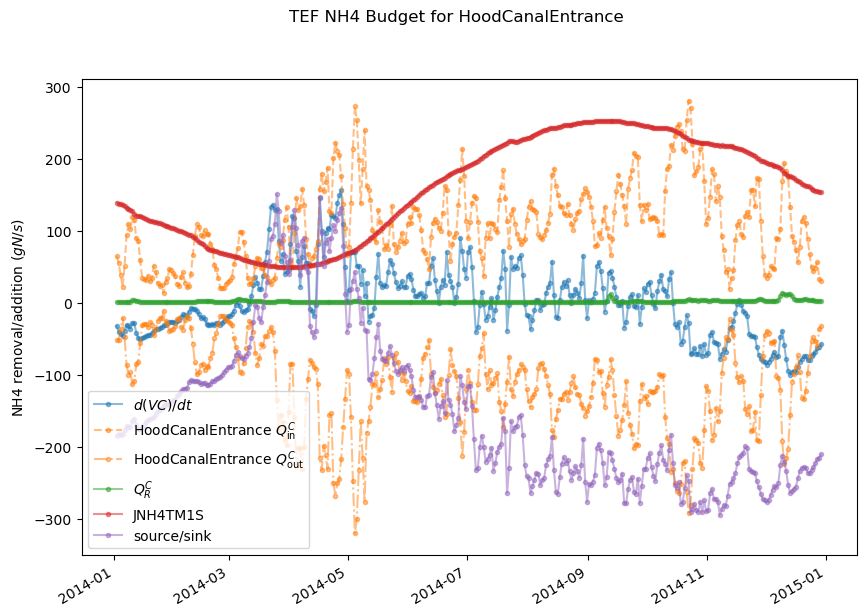

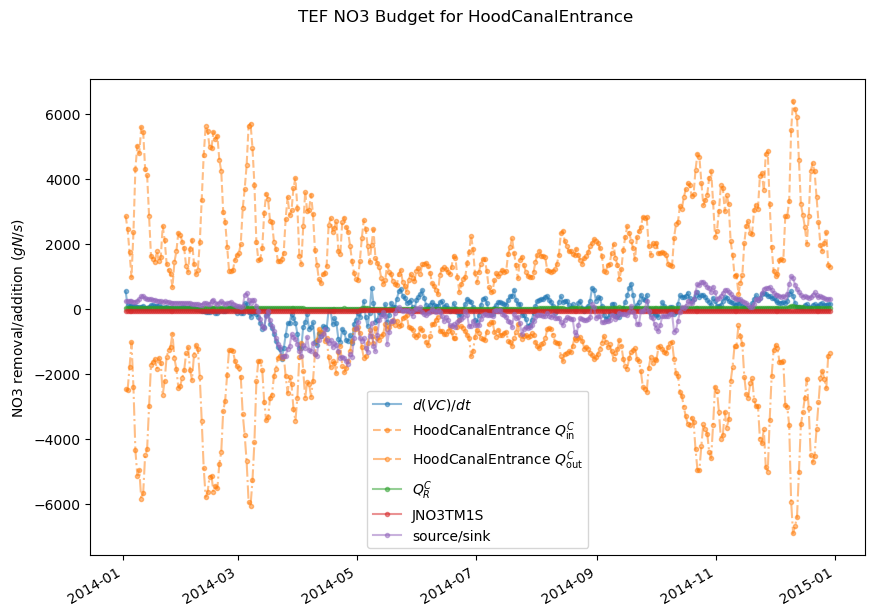

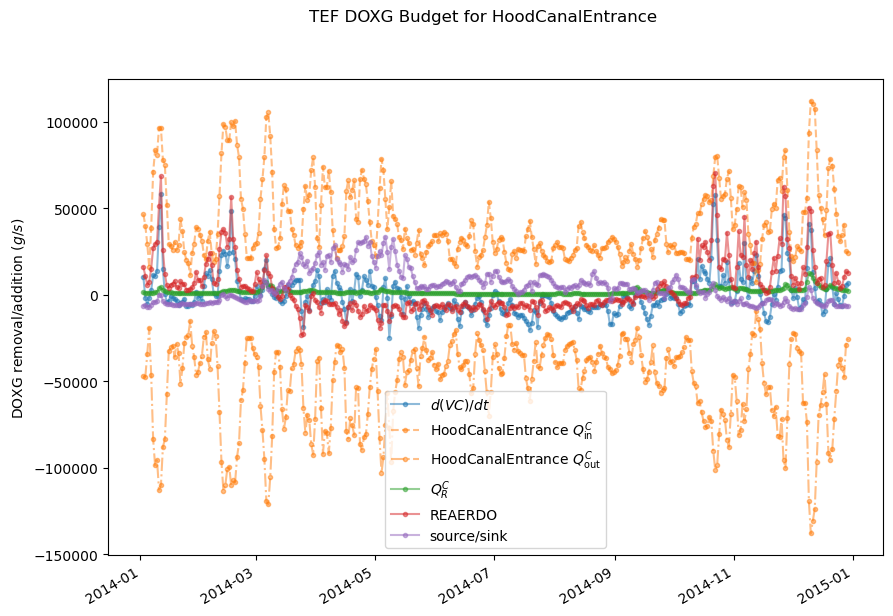

In [35]:
for s in statevars:
    fig, ax = plot_budget(tef_cst_budgets[s])
    
    unit = hydro_output[s].units
    if unit.endswith(' meters-3'):
        # Cancel out the volumes
        unit = unit.removesuffix(' meters-3') + '/s'
    elif unit == 'MG/L':
        unit = 'g/s'
    else:
        unit += '-m^3/s'
    ax.set(ylabel=f"{s} removal/addition (${unit}$)")
    ax.legend()
    fig.autofmt_xdate()
    fig.suptitle(f'TEF {s} Budget for {", ".join(section_names)}')
    fig.savefig(out_file(f'tef_{s}_budget.png'))